## PDF Text extraction & chunking

### PDF to text

PDFs contain rich formatting that needs to be extracted as clean text for AI processing. 

Modern libraries like `docling` can preserve document structure while converting to text format, making the text easier to process while maintaining semantic relationships.

Inspect a PDF converted with `docling`:

In [ ]:
from pathlib import Path

md_filepath = Path("data/parsed/amazon-2025-08-8k-excerpts-parsed-text.md")
md_txt = md_filepath.read_text()
print(md_txt[:500])

amazon

<!-- image -->

## AMAZON.COM ANNOUNCES SECOND QUARTER RESULTS

SEATTLE-(BUSINESS WIRE) July 31, 2025-Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its second quarter ended June 30, 2025.

- Net sales increased 13% to $167.7 billion in the second quarter, compared with $148.0 billion in second quarter 2024. Excluding the $1.5 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 12% compared with


Tables preserve their formatting:

In [2]:
table_example = md_txt.split("## Consolidated Statements of Operations")[1]
print(table_example[:2000])



(in millions, except per share data)

(unaudited)

|                                                                    | Three Months Ended June 30,   | Three Months Ended June 30,   | Six Months Ended June 30,   | Six Months Ended June 30,   |
|--------------------------------------------------------------------|-------------------------------|-------------------------------|-----------------------------|-----------------------------|
|                                                                    | 2024                          | 2025                          | 2024                        | 2025                        |
| Net product sales                                                  | $ 61,569                      | $ 68,246                      | $ 122,484                   | $ 132,216                   |
| Net service sales                                                  | 86,408                        | 99,456                        | 168,806                     | 19

### Chunking

Raw text from PDFs is often too long for AI models to process effectively. Chunking breaks documents into smaller, manageable pieces while preserving context. 

#### Chunk by text length

Fixed-length chunks are simple but can break sentences or paragraphs mid-thought. This approach is fast and predictable, making it suitable for initial processing or when document structure is uniform.

![images/chunking_why.png](images/chunking_why.png)

Different chunking strategies serve different use cases. 

![images/chunking_methods.png](images/chunking_methods.png)

Let's try a few options:

#### Chunk by text length with overlap

Overlapping chunks help maintain context across boundaries. 

When a concept spans multiple chunks, the overlap helps to capture it. This is especially important for maintaining semantic coherence in search and retrieval systems.

In [3]:
def get_chunks_by_length_with_overlap(src_text: str, chunk_length: int = 500, overlap: int = 100) -> list[str]:
    """
    Split text into chunks of approximately `chunk_length` characters.
    """
    chunks = []
    for i in range(0, len(src_text), chunk_length):
        chunks.append(src_text[i:i + chunk_length + overlap])
    return chunks

In [ ]:
# STUDENT TODO
# Chunk `md_text_1` with `get_chunks_by_length_with_overlap`
# Inspect the first 3 or so chunks
# START_SOLUTION
chunks = get_chunks_by_length_with_overlap(md_txt)

for chunk in chunks[:3]:
    print(f"Chunk length: {len(chunk)}\n" + "-"*20)
    print(chunk)
# END_SOLUTION

['amazon\n\n<!-- image -->\n\n## AMAZON.COM ANNOUNCES SECOND QUARTER RESULTS\n\nSEATTLE-(BUSINESS WIRE) July 31, 2025-Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its second quarter ended June 30, 2025.\n\n- Net sales increased 13% to $167.7 billion in the second quarter, compared with $148.0 billion in second quarter 2024. Excluding the $1.5 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 12% compared with second quarter 2024.\n- North America segment sales increased 11% year-over-year to $100.1 billion.\n',
 ' second quarter 2024.\n- North America segment sales increased 11% year-over-year to $100.1 billion.\n- International segment sales increased 16% year-over-year to $36.8 billion, or increased 11% excluding changes in foreign exchange rates.\n- AWS segment sales increased 17.5% year-over-year to $30.9 billion.\n- Operating income increased to $19.2 billion in the second quarter, co

600


#### Chunk using markers

Using document markers (like headers) creates chunks that respect natural document boundaries. 

This approach preserves semantic structure and is ideal for documents with clear hierarchical organization like reports, manuals, or academic papers.

In [5]:
def get_chunks_using_markers(src_text: str) -> list[str]:
    """
    Split the source text into chunks using markers.
    """
    marker = "\n##"

    # Split by marker and reconstruct with markers (except first chunk)
    parts = src_text.split(marker)
    chunks = []

    # Add first chunk if it exists and isn't empty
    if parts[0].strip():
        chunks.append(parts[0].strip())

    # Add remaining chunks with markers reattached
    for part in parts[1:]:
        if part.strip():
            chunks.append(marker + part.strip())

    return chunks

In [ ]:
md_file_1 = Path("data/parsed/amazon-2025-08-8k-excerpts-parsed-text.md")
md_text_1 = md_file_1.read_text(encoding="utf-8")

# STUDENT TODO
# Chunk `md_text_1` with `get_chunks_using_markers`
# Inspect the first few chunks
# START_SOLUTION
chunks = get_chunks_using_markers(md_text_1)

for chunk in chunks[:3]:
    print(f"Chunk length: {len(chunk)}\n" + "-"*20)
    print(chunk)
# END_SOLUTION



Chunk: ==========
amazon

<!-- image -->


Chunk: ==========

##AMAZON.COM ANNOUNCES SECOND QUARTER RESULTS

SEATTLE-(BUSINESS WIRE) July 31, 2025-Amazon.com, Inc. (NASDAQ: AMZN) today announced financial results for its second quarter ended June 30, 2025.

- Net sales increased 13% to $167.7 billion in the second quarter, compared with $148.0 billion in second quarter 2024. Excluding the $1.5 billion favorable impact from year-over-year changes in foreign exchange rates throughout the quarter, net sales increased 12% compared with second quarter 2024.
- North America segment sales increased 11% year-over-year to $100.1 billion.
- International segment sales increased 16% year-over-year to $36.8 billion, or increased 11% excluding changes in foreign exchange rates.
- AWS segment sales increased 17.5% year-over-year to $30.9 billion.
- Operating income increased to $19.2 billion in the second quarter, compared with $14.7 billion in second quarter 2024.
- North America segment operatin

## Working with PDFs with images

PDFs contain more than rich formatting - they have images!

Run the cells below to convert PDF data to images (this should take about a minute). 

In [ ]:
try:
    import pymupdf
except ImportError:
    %pip install -Uqq pymupdf

In [2]:
%%bash
python pdf_to_img.py WEF*.pdf
echo "Images extracted from AI report PDF"

Converting data/pdfs/WEF_Artificial_Intelligence_in_Financial_Services_2025.pdf to images...
Converted 27 pages to images
Images extracted from AI report PDF


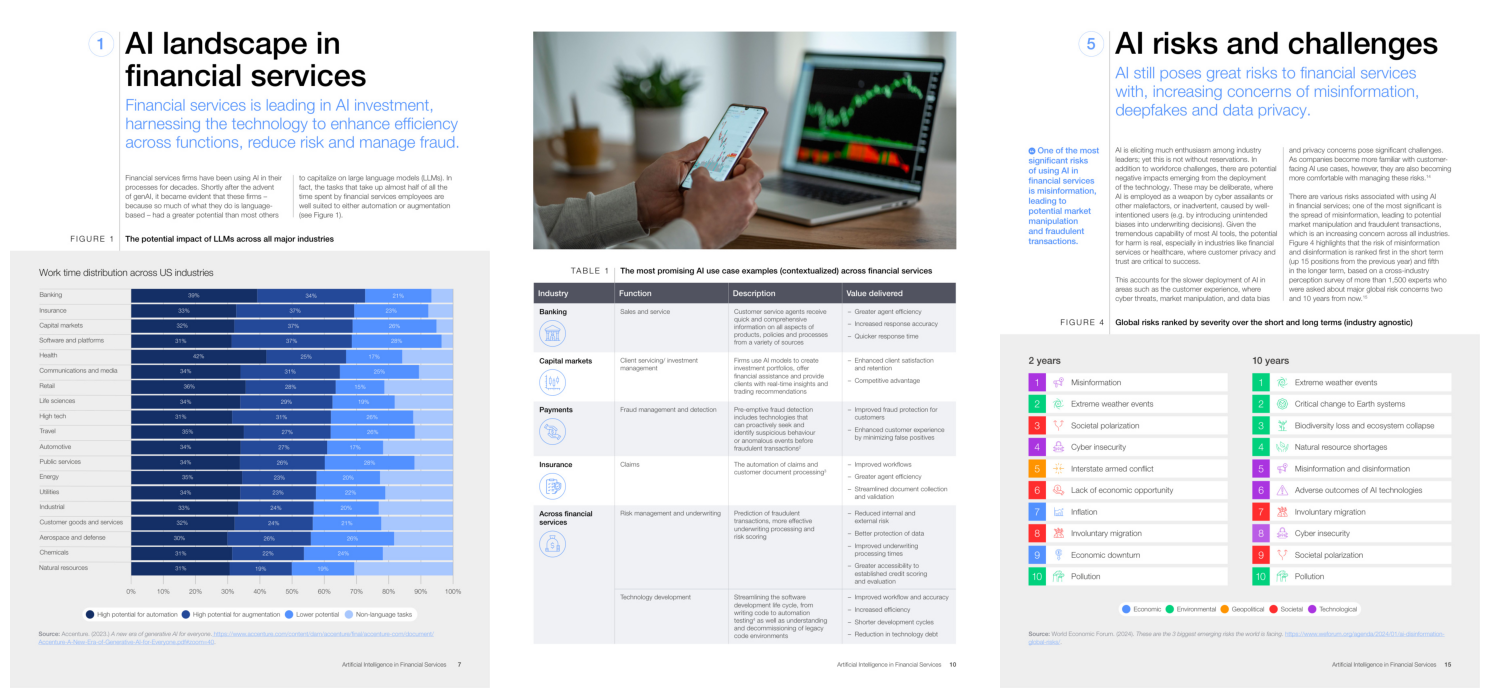

In [4]:
import matplotlib.pyplot as plt
from PIL import Image

images = [
    f"data/imgs/WEF_Artificial_Intelligence_in_Financial_Services_2025_07_of_27.jpg",
    f"data/imgs/WEF_Artificial_Intelligence_in_Financial_Services_2025_10_of_27.jpg",
    f"data/imgs/WEF_Artificial_Intelligence_in_Financial_Services_2025_15_of_27.jpg"
]

fig, axes = plt.subplots(1, 3, figsize=(15, 40))

for i, img_path in enumerate(images):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Approach 1 - Extract text and images separately

Some libraries (like `docling`) can extract text and images from PDFs, and convert them into Markdown files.

Here, we've pre-converted this PDF into markdown.

In [ ]:
from pathlib import Path

md_filepath = Path("data/parsed/hai_ai-index-report-2025_chapter2_excerpts-parsed-w-imgs.md")
md_txt = md_filepath.read_text()
print(md_txt[:1000])

## Chapter 2: Technical Performance

## RAG: Retrieval Augment Generation (RAG)

An  increasingly  common  capability  being  tested  in  LLMs is retrieval-augmented generation (RAG). This approach integrates LLMs  with retrieval mechanisms  to enhance their  response  generation. The  model fi rst  retrieves  relevant information  from fi les  or  documents  and  then  generates  a response tailored to the user's query based on the retrieved content.  RAG  has  diverse  use  cases,  including  answering precise questions from large databases and addressing customer queries using information from company documents.

models. 2024 also saw the release of numerous benchmarks for  evaluating  RAG  systems,  including  Ragnarok  (a  RAG arena battleground) and CRAG (Comprehensive RAG benchmark). Additionally, specialized RAG benchmarks, such as FinanceBench for fi nancial question answering, have been developed to address speci fi c use cases.

## Berkeley Function Calling Leaderboard

In r

#### Chunking text files with images

More complex than just text, since we need to handle images as well.

- Must include entire image string in the chunk
- When vectorizing, optionally include base64 of image
    - Your embedding model must be multimodal

Chunking becomes more complex.

One method: try a specialized library like `chonkie` to handle this

Chonkie offers a variety of chunking strategies:

<img src="images/chonkie_methods.png" />

There isn't going to be a "one size fits all" solution for chunking PDFs with images. But these libraries can help you get started.

Let's try a couple of different approaches:

In [ ]:
%pip install -Uqq "chonkie[all]"

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from chonkie import RecursiveChunker

# Initialize the recursive chunker to chunk Markdown
chunker = RecursiveChunker.from_recipe("markdown", lang="en")

In [ ]:
chunk_texts = chunker.chunk(md_txt)

In [ ]:
import textwrap

for chunk in chunk_texts[:5]:
    print(f"\n" + "=" * 40)
    print(f"Token count: {chunk.token_count}")
    print(f"Chunk text:")
    wrapped_text = textwrap.fill(chunk.text[:500]+"...", width=80)
    print(textwrap.indent(wrapped_text, "    "))


Token count: 1681
Chunk text:
    ## Chapter 2: Technical Performance  ## RAG: Retrieval Augment Generation (RAG)
    An  increasingly  common  capability  being  tested  in  LLMs is retrieval-
    augmented generation (RAG). This approach integrates LLMs  with retrieval
    mechanisms  to enhance their  response  generation. The  model fi rst  retrieves
    relevant information  from fi les  or  documents  and  then  generates  a
    response tailored to the user's query based on the retrieved content.  RAG  has
    diverse  use  cases,  including  ...

Token count: 1793
Chunk text:
    ## Berkeley Function-Calling Leaderboard Evaluation Data Composition
    ![Image](data/parsed/hai_ai-index-report-2025_chapter2_excerpts-parsed-w-imgs_ar
    tifacts/image_000000_7d6b2eec7e2a34253b28c23b7501ca8fbb4a6b25b9f0adb845f99f865bb
    f518a.png)  Figure 2.2.17 9  | Javascript (AST)          | Chatting Capability
    | |---------------------------|---------------------------------| | 2.5%
    |

Let's try a "semantic" chunker:

In [ ]:
from chonkie import SemanticChunker

# Basic initialization with default parameters
chunker = SemanticChunker(
    embedding_model="minishlab/potion-base-8M",  # Default model
    threshold=0.5,                               # Similarity threshold (0-1) or (1-100) or "auto"
    chunk_size=2048,                             # Maximum tokens per chunk
    min_sentences=1                              # Initial sentences per chunk
)

In [ ]:
chunk_texts = chunker.chunk(md_txt)

In [ ]:
for chunk in chunk_texts[:5]:
    print(f"\n" + "=" * 40)
    print(f"Token count: {chunk.token_count}")
    print(f"Chunk text:")
    wrapped_text = textwrap.fill(chunk.text[:500]+"...", width=80)
    print(textwrap.indent(wrapped_text, "    "))


Token count: 183
Chunk text:
    ## Chapter 2: Technical Performance  ## RAG: Retrieval Augment Generation (RAG)
    An  increasingly  common  capability  being  tested  in  LLMs is retrieval-
    augmented generation (RAG). This approach integrates LLMs  with retrieval
    mechanisms  to enhance their  response  generation. The  model fi rst  retrieves
    relevant information  from fi les  or  documents  and  then  generates  a
    response tailored to the user's query based on the retrieved content.  RAG  has
    diverse  use  cases,  including  ...

Token count: 125
Chunk text:
     In recent years, RAG has received increasing attention from researchers  and
    companies.  For  example,  in  September 2024, Anthropic introduced Contextual
    Retrieval, a method that signi fi cantly enhances the retrieval capabilities of
    RAG  The  Berkeley  Function  Calling  Leaderboard  evaluates  the ability  of
    LLMs  to  accurately  call  functions  or  tools.  The evaluation suite in

We get a relatively "even" distribution of chunks here. 

So let's continue on with this approach. 